# $\text{Jane Street Market Prediction}$

## $\text{Getting the data}$

## For Oscar:

In [128]:
# Data
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500) #arbitrary large number, I wanna see all columns


# Plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#utilities
import os
from collections import Counter
import random
random.seed(42)

In [129]:
%%time
working_dir = "/Users/oscarengelbrektson/Documents/Minerva/Spring 2021 - San Francisco/Quantitative Trading/Jane Street Competition/data/"

train_data = pd.read_csv(working_dir + "train.csv")
test_data_sample = pd.read_csv(working_dir + "example_test.csv")
feature_data = pd.read_csv(working_dir + "features.csv")


CPU times: user 57 s, sys: 12 s, total: 1min 9s
Wall time: 1min 12s


In [208]:
#number of trades with atleast 1 missing value
train_data.isnull().values.ravel().sum()

6762701

In [209]:
#Average Missing values per observations
6762701 / train_data.shape[0]

2.8290008203335635

## For Taha

In [1]:
# getting access to Google Drive to retrieve data
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# changing the working directory
#%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [3]:
'''
!kaggle competitions download -c jane-street-market-prediction
!unzip \*.zip  && rm *.zip''';

In [7]:
%%time
train_data = pd.read_csv('C:/Users/Taha/Desktop/Spring 2021/JaneStreet/train.csv')

Wall time: 2min 7s


In [9]:
# difference columns between train and test set
#set(train_data.columns) - set(test_sample.columns)

## $\text{LightGMB}$

### $\text{Data Processing}$

In [130]:
#Get outcome variable by transforming resp > 0
train_data["action"] = train_data["resp"].apply(lambda x: int(x>0))

In [131]:
#Train-validation-test split : 300-100-100
train_set = train_data[train_data.date < 300]
validation_set = train_data[(train_data.date >= 300) & (train_data.date < 400)]
test_set = train_data[train_data.date >= 400]

train_set.date.nunique(), validation_set.date.nunique(), test_set.date.nunique()

(300, 100, 100)

In [132]:
# percentage of trades in the test set
round(100*validation_set.shape[0] / (train_data.shape[0]), 2)

19.88

In [134]:
outcomes = ['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'action', 'ts_id']
predictors = list(filter(lambda x: x not in outcomes, train_data.columns))
outcome = ['action']

In [135]:
X_train, X_validation, y_train, y_validation = train_set[predictors],  validation_set[predictors], train_set[outcome], validation_set[outcome]
X_test, y_test = test_set[predictors], test_set[outcome]


### $\text{LightGBM: One Split}$

In [136]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import lightgbm as lgb

In [137]:


#print(X_train.shape, X_validation.shape, y_train.shape, y_validation.shape)

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train.values.reshape(len(y_train),), verbose=True)

LGBMClassifier()

In [138]:
y_pred = lgb_model.predict(X_validation)

In [139]:
print("Accuracy of model is: ", accuracy_score(y_validation, y_pred))

Accuracy of model is:  0.5148584846113061


In [140]:
print('Training set score: {:.4f}'.format(lgb_model.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(lgb_model.score(X_validation, y_validation)))

Training set score: 0.5663
Test set score: 0.5149


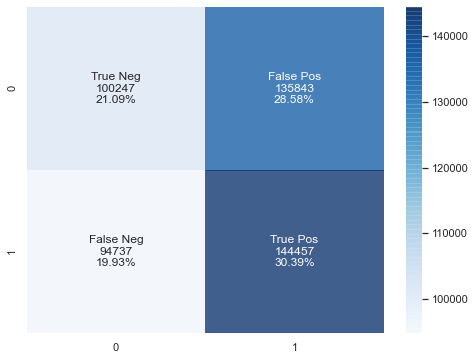

In [141]:
import seaborn as sns

def plot_cm(cm):
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.set(rc={'figure.figsize':(8, 6)})
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', alpha=.75)
    
plot_cm(confusion_matrix(y_validation, y_pred));

### $\text{Hyperparameter Tunning: Bayesian Optimization}$

In [142]:
def lgbm_cv(learning_rate, num_leaves, 
            min_data_in_leaf, max_bin,
            max_depth):
    
    estimator_function = lgb.LGBMClassifier(max_depth=int(max_depth),
                                            learning_rate = learning_rate,
                                            num_leaves = int(num_leaves),
                                            min_data_in_leaf = int(min_data_in_leaf),
                                            max_bin=int(max_bin),
                                            objective = 'binary', 
                                            boosting= 'gbdt',
                                            nthread=10,
                                            seed = 42,
                                            verbose = -1)
    
    estimator_function.fit(X_train, y_train.values.reshape(len(y_train),))
    probs = estimator_function.predict_proba(X_validation)[:,1]
    return roc_auc_score(y_validation, probs)

In [143]:
from bayes_opt import BayesianOptimization

gp_params = {"alpha": 1e-10}

hp_space = {'learning_rate': (0.001, 0.1),
          'num_leaves': (100, 300),
          'min_data_in_leaf': (5, 20),
          'max_bin': (150, 250),
          'max_depth': (2, 15)}

lgbcBO = BayesianOptimization(f=lgbm_cv, pbounds=hp_space, random_state=42, verbose=-1)

In [144]:
lgbcBO.maximize(init_points=5, n_iter=20, acq='ucb', kappa= 3, **gp_params)

|   iter    |  target   | learni... |  max_bin  | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------
[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  1        |  0.5189   |  0.03808  |  245.1    |  11.52    |  13.98    |  131.2    |
[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  2        |  0.5195   |  0.01644  |  155

|  17       |  0.5164   |  0.01722  |  160.1    |  5.093    |  18.68    |  259.0    |
[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  18       |  0.5179   |  0.03093  |  156.7    |  14.93    |  13.53    |  241.7    |
[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  19       |  0.5187   |  0.09406  |  243.7    |  11.65    |  14.91    |  132.5    |
[LightGBM] [Warning] num_threads is set wi

In [145]:
#Best accuracy:
lgbcBO.max["target"]

0.5195743023744539

In [146]:
best_params = lgbcBO.max["params"]
best_params

{'learning_rate': 0.02040113329924893,
 'max_bin': 157.8854917508492,
 'max_depth': 13.19156493728931,
 'min_data_in_leaf': 16.500402969690814,
 'num_leaves': 241.9229030044085}

## Train model with best hyperparameters on train set

In [147]:
validated_lgbm_model = lgb.LGBMClassifier(max_depth=int(round(best_params["max_depth"])),
                                            learning_rate = best_params["learning_rate"],
                                            num_leaves = int(round(best_params["num_leaves"])),
                                            min_data_in_leaf = int(round(best_params["min_data_in_leaf"])),
                                            max_bin=int(round(best_params["max_bin"])),
                                            objective = 'binary', 
                                            boosting= 'gbdt',
                                            nthread=10,
                                            seed = 42,
                                            verbose = -1)

In [148]:
validated_lgbm_model.fit(train_set[predictors],
                     train_set[outcome].values.reshape(len(train_set),), 
                     verbose=True)

[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMClassifier(boosting='gbdt', learning_rate=0.02040113329924893, max_bin=158,
               max_depth=13, min_data_in_leaf=17, nthread=10, num_leaves=242,
               objective='binary', seed=42, verbose=-1)

# Compute utility score depending on decision threshold'

In [149]:
y_pred_probs = validated_lgbm_model.predict_proba(X_validation)

In [150]:
validation_set["lgbm_predicted_prob"] = y_pred_probs[:, 1] #Probability of target=1

<ipython-input-150-9d3c100330eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set["lgbm_predicted_prob"] = y_pred_probs[:, 1] #Probability of target=1


In [151]:
def utility_score_last(date, weight, resp, action):
    '''
    Takes four 1-d arrays of equal size:
    Date: int
    weight: float >= 0
    resp: float
    action: binary
    
    and returns jane street utility score, u
    '''
    count_i = date.nunique() # Get number of days
    P_i = np.bincount(date, weight * resp * action) # Compute P_i
    t = np.sum(P_i) / np.sqrt(np.sum(P_i ** 2)) * np.sqrt(250 / count_i) # Compute t
    u = np.clip(t, 0, 6) * np.sum(P_i) # Combine to get utility score
    return u

def get_utility_from_df(df, decision_threshold=0.5):
    '''
    Takes a dataframe and a decision threshold, 
    computes the total utility given the decision threshold for converting predicted probabilities to actions
    '''
    return utility_score_last(df.date, df.weight, df.resp, 
                              df.lgbm_predicted_prob.apply(lambda proba: int(proba > decision_threshold)))

In [152]:
thresholds =  np.linspace(0, 1, 200)
utility_by_threshold = [get_utility_from_df(validation_set, threshold) for threshold in thresholds]

<ipython-input-151-1f5466e7d848>:13: RuntimeWarning: invalid value encountered in double_scalars
  t = np.sum(P_i) / np.sqrt(np.sum(P_i ** 2)) * np.sqrt(250 / count_i) # Compute t


In [153]:
best_threshold = thresholds[utility_by_threshold.index(max(utility_by_threshold))]

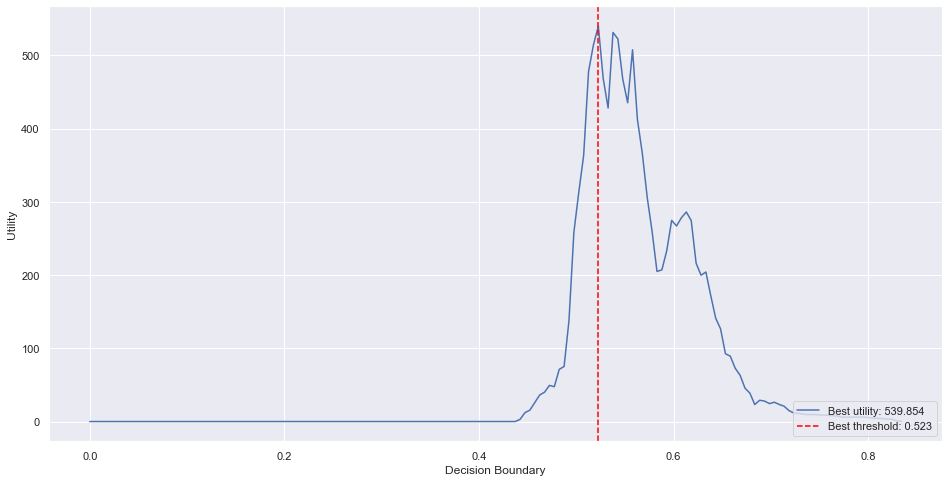

In [154]:
# Visualize
plt.figure(figsize=(16, 8))
plt.plot(thresholds, utility_by_threshold, label="Best utility: %s"%np.round(max(utility_by_threshold), 3))
plt.axvline(best_threshold, 
            color="red", linestyle="--",label="Best threshold: %s"%np.round(best_threshold, 3))
plt.ylabel("Utility")
plt.xlabel("Decision Boundary")
plt.legend(loc=4)
plt.show()

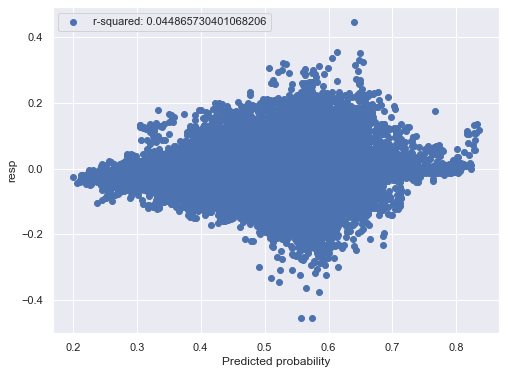

In [155]:
plt.scatter(validation_set.lgbm_predicted_prob, validation_set.resp, label="r-squared: {}".format(np.corrcoef(validation_set.lgbm_predicted_prob,
                                                                                             validation_set.resp)[0,1]))
plt.xlabel("Predicted probability")
plt.ylabel("resp")

plt.legend(loc=0)
plt.show()

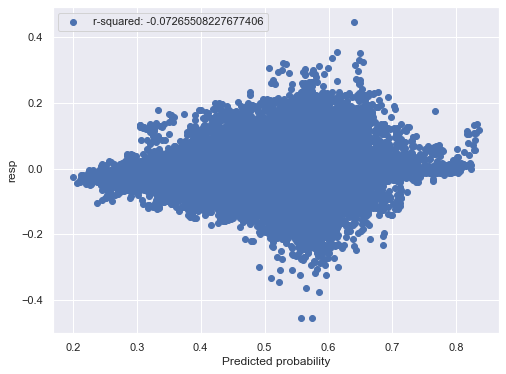

In [156]:
plt.scatter(validation_set.lgbm_predicted_prob, validation_set.resp, label="r-squared: {}".format(np.corrcoef(validation_set.lgbm_predicted_prob,
                                                                                             validation_set.weight)[0,1]))
plt.xlabel("Predicted probability")
plt.ylabel("resp")

plt.legend(loc=0)
plt.show()

# Train best model on entire train + validation dataset before running on test

In [157]:
#Merge train and validation data into a single dataframe
validation_set.drop(columns=["lgbm_predicted_prob"], axis=1, inplace=True)
train_and_validation_set = pd.concat([train_set, validation_set], axis=0)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [158]:
#Define model with best hyperparameters based on validation set
final_lgbm_model = lgb.LGBMClassifier(max_depth=int(round(best_params["max_depth"])),
                                            learning_rate = best_params["learning_rate"],
                                            num_leaves = int(round(best_params["num_leaves"])),
                                            min_data_in_leaf = int(round(best_params["min_data_in_leaf"])),
                                            max_bin=int(round(best_params["max_bin"])),
                                            objective = 'binary', 
                                            boosting= 'gbdt',
                                            nthread=10,
                                            seed = 42,
                                            verbose = -1)

In [189]:
final_lgbm_model = lgb.LGBMClassifier(boosting='gbdt', learning_rate=0.06157343657751557, max_bin=164,
               max_depth=6, min_data_in_leaf=10, nthread=10, num_leaves=191,
               objective='binary', seed=42, verbose=-1)

In [190]:
#Train on merged dataset
final_lgbm_model.fit(train_and_validation_set[predictors],
                     train_and_validation_set[outcome].values.reshape(len(train_and_validation_set),), 
                     verbose=True)

[LightGBM] [Warning] num_threads is set with nthread=10, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMClassifier(boosting='gbdt', learning_rate=0.06157343657751557, max_bin=164,
               max_depth=6, min_data_in_leaf=10, nthread=10, num_leaves=191,
               objective='binary', seed=42, verbose=-1)

### Save model as pickle file to avoid having to retrain

In [187]:
import joblib
# save model
#joblib.dump(final_lgbm_model, 'final_lgbm_model_final.pkl')
# load model
gbm_pickle = joblib.load('final_lgbm_model.pkl')

In [188]:
gbm_pickle

LGBMClassifier(boosting='gbdt', learning_rate=0.06157343657751557, max_bin=164,
               max_depth=6, min_data_in_leaf=10, nthread=10, num_leaves=191,
               objective='binary', seed=42, verbose=-1)

# Compute test set utility

In [182]:
y_preds = gbm_pickle.predict_proba(X_test)

In [183]:
test_set["lgbm_predicted_prob"] = y_preds[:, 1]

<ipython-input-183-ff5a00e50ae4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["lgbm_predicted_prob"] = y_preds[:, 1]


In [184]:
get_utility_from_df(test_set, best_threshold)

1100.0256097161034

# Original model
We had a a faulty line of code originally, which resulted in the order of the features in each X set being randomly scrambled whenever the notebook was restarted. We had a model that we trained for a very long time, but which was lost when the kernel crashed. We saved the model itself, but because the order of the features was randomly scrambled, we can't use the features. However, we can train another model using the same hyperparameters derived from running the bayesian optimization for extremely finegrained, and larger search spans–something we don't have time to do again before the submission.

You can verify this by checking the GitHub date that final_lgbm_model.pkl was pushed to the repo–it was the first model to be pushed.

In [191]:
joblib.load('final_lgbm_model.pkl')

LGBMClassifier(boosting='gbdt', learning_rate=0.06157343657751557, max_bin=164,
               max_depth=6, min_data_in_leaf=10, nthread=10, num_leaves=191,
               objective='binary', seed=42, verbose=-1)

In [192]:
original_lgbm_model = lgb.LGBMClassifier(boosting='gbdt', learning_rate=0.06157343657751557, max_bin=164,
               max_depth=6, min_data_in_leaf=10, nthread=10, num_leaves=191,
               objective='binary', seed=42, verbose=-1)

In [193]:
#Train on merged dataset
original_lgbm_model.fit(train_and_validation_set[predictors],
                     train_and_validation_set[outcome].values.reshape(len(train_and_validation_set),), 
                     verbose=True)

LGBMClassifier(boosting='gbdt', learning_rate=0.06157343657751557, max_bin=164,
               max_depth=6, min_data_in_leaf=10, nthread=10, num_leaves=191,
               objective='binary', seed=42, verbose=-1)

In [194]:
y_preds = original_lgbm_model.predict_proba(X_test)

In [195]:
test_set["lgbm_predicted_prob"] = y_preds[:, 1]

<ipython-input-195-ff5a00e50ae4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["lgbm_predicted_prob"] = y_preds[:, 1]


In [207]:
get_utility_from_df(test_set, best_threshold)

1790.9018447946748

# Abandoned approach using TimeSeriesSplit:
Abandoned because was not computationally feasible, would shortcircuit my computers RAM when we tried to use it for hyperparameter selection

In [10]:
from sklearn.model_selection import TimeSeriesSplit

#Number of trades in each split, with TimeSeriesSplit
X_train, y_train = train_set[predictors], train_set[outcome]
ts = TimeSeriesSplit(n_splits=4)
for i in ts.split(X_train, y_train):
    print(len(i[0]), len(i[1]))

280617 280613
561230 280613
841843 280613
1122456 280613


In [11]:
#Number of dates in each split, with TimeSeriesSplit

ts = TimeSeriesSplit(n_splits=4)
for fold_index, holdout_index in ts.split(X_train, y_train):     
    X_fold, X_holdout = X_train.iloc[fold_index,:].date.nunique(), X_train.iloc[holdout_index,:].date.nunique()
    print('Train: {}, Test: {}'.format(X_fold, X_holdout))

Train: 44, Test: 53
Train: 96, Test: 75
Train: 170, Test: 68
Train: 237, Test: 64


In [ ]:
import gc

n_folds = 4
folds = TimeSeriesSplit(n_splits=n_folds)

splits = folds.split(train_set[predictors], train_set[outcome])

y_preds = np.zeros(validation_set.shape[0])
y_oof = np.zeros(train_set.shape[0])
mean_score = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = predictors

for fold_n, (train_index, valid_index) in enumerate(splits):

    print('Fold:', fold_n+1)
    
    X_train, X_valid = train_set[predictors].iloc[train_index], train_set[predictors].iloc[valid_index]
    y_train, y_valid = train_set[outcome].iloc[train_index], train_set[outcome].iloc[valid_index]

    d_train = lgb.Dataset(X_train, label=y_train)
    d_valid = lgb.Dataset(X_valid, label=y_valid)

    model = lgb.train(params, d_train, 2500, valid_sets = [d_train, d_valid], early_stopping_rounds = 50, verbose_eval=100)
    
    feature_importances[f'fold_{fold_n + 1}'] = model.feature_importance()

    y_pred_valid = np.round(model.predict(X_valid, num_iteration=model.best_iteration))

    y_oof[valid_index] = y_pred_valid
    
    val_score = accuracy_score(y_pred_valid, y_valid)

    print(f'val AUC score is {val_score}')

    mean_score.append(val_score)

    y_preds += model.predict(validation_set[predictors], num_iteration=model.best_iteration) / n_folds

    del X_train, X_valid, y_train, y_valid
    gc.collect()

print('AUC score over folds is', np.mean(mean_score))

#test['demand'] = y_preds

In [ ]:
# Parameters for lightGBM. Objective is minimizing logloss
params = {'learning_rate': 0.01,
          'boosting': 'gbdt',
          'objective': 'binary',
          'num_leaves': 200,
          'min_data_in_leaf': 10,
          'max_bin': 200,
          'max_depth': 6,
          'seed': 2018,
          'nthread': 10}

In [117]:
gbm_pickle = joblib.load('final_lgbm_model.pkl')
asd = predictors.copy()
new_test = test_set[asd]
y_preds = gbm_pickle.predict_proba(new_test)

In [119]:
y_preds[:, 1]

array([0.56173588, 0.56349285, 0.52683315, ..., 0.49245976, 0.48022083,
       0.27745093])

In [120]:
test_set["lgbm_predicted_prob"]

1878353    0.497785
1878354    0.482919
1878355    0.493979
1878356    0.494053
1878357    0.469061
             ...   
2390486    0.530731
2390487    0.474560
2390488    0.499953
2390489    0.737711
2390490    0.572586
Name: lgbm_predicted_prob, Length: 512138, dtype: float64